In [1]:
from matplotlib import pyplot as plt
from src.conf.config import CONFIG
from src.tune.tune_experiment import (
    TuneReportCallback, CheckpointCallback,
    train_tune_checkpoint, tune_pbt
)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can&#39;t resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/u

In [90]:
import sklearn.feature_extraction.image
im = np.ones((1000, 1000, 3))
input_size=256
stride_size=input_size//2
pad = stride_size//2
io = np.pad(im, [(pad, pad), (pad, pad), (0, 0)], mode="reflect")

# add extra padding to match an exact multiple of 32 (unet) patch size, 
extra_pad_row = int(np.ceil(io.shape[0] / input_size)*input_size - io.shape[0])
extra_pad_col = int(np.ceil(io.shape[1] / input_size)*input_size - io.shape[1])
io = np.pad(io, [(0, extra_pad_row), (0, extra_pad_col), (0, 0)], mode="constant")

# extract the patches from input images
arr_out = sklearn.feature_extraction.image.extract_patches(
    io, (input_size, input_size, 3), stride_size
)

# shape the dimensions to correct sizes for pytorch model
arr_out_shape = arr_out.shape
arr_out = arr_out.reshape(-1, input_size, input_size, 3)

In [91]:
print(arr_out.shape)
print(arr_out_shape)
patches_shape = arr_out_shape
pred_patches = arr_out 

(81, 256, 256, 3)
(9, 9, 1, 256, 256, 3)


In [92]:
# pred_patches = pred_patches.reshape(
#     patches_shape[0], 
#     patches_shape[1], 
#     input_size, 
#     input_size,
#     patches_shape[-1]
# ) # (num_tile_x, num_tile_y, H, W, C)
print(pred_patches.shape)

# remove the padding from each tile, we only keep the center
pad = stride_size//2
pred_patches = pred_patches[:, pad:-pad, pad:-pad, :]
print(pred_patches.shape)

# turn all the tiles into an image
pred = pred_patches.reshape(im.shape[0], im.shape[1], patches_shape[-1])
print(pred.shape)

# incase there was extra padding to get a multiple of patch size, remove that as well
# remove paddind, crop back
pred = pred[0:im.shape[0], 0:im.shape[1], :]
print(pred.shape)

(81, 256, 256, 3)
(81, 128, 128, 3)


ValueError: cannot reshape array of size 3981312 into shape (1000,1000,3)

In [44]:
pred.shape

(1000, 1000, 3)

In [17]:
g.squeeze()

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

In [2]:
config = CONFIG
analysis = tune_pbt(config, num_samples=3, num_epochs=4, gpus_per_trial=1, notebook=True)

Trial name,status,loc,edge_weight,lr,batch_size
DEFAULT_493c2_00000,RUNNING,,1,0.001,6
DEFAULT_493c2_00001,PENDING,,1,0.001,6
DEFAULT_493c2_00002,PENDING,,1,0.001,6


(pid=17138) /usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:
(pid=17138) 
(pid=17138) numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
(pid=17138) 
(pid=17138) /usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:
(pid=17138) 
(pid=17138) numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
(pid=17138) 
(pid=17138) /usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:
(pid=17138) 
(pid=17138) numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
(pid=17138) 
(pid=17138) /usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:
(pid=17138) 
(pid=17138) numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
(pid=17138) 
(pid=17138) /usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:
(pid=17138) 
(pid=17138) can&#39;t resolve pa

In [3]:
analysis.fetch_trial_dataframes()
analysis.get_best_logdir(metric="avg_val_accuracy")
analysis.get_best_trial(metric="avg_val_accuracy")
analysis.get_trial_checkpoints_paths(analysis.get_best_trial(metric="avg_val_accuracy"))
analysis.trials

[DEFAULT_89ede_00000, DEFAULT_89ede_00001, DEFAULT_89ede_00002]

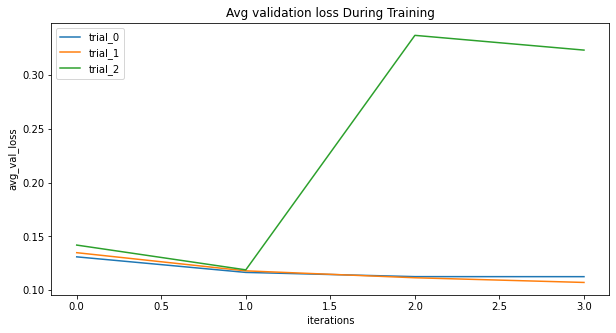

In [5]:
lossG = [df['avg_val_loss'].tolist() for df in list(analysis.trial_dataframes.values())]
plt.figure(figsize=(10,5))
plt.title("Avg validation loss During Training")
for i, lossg in enumerate(lossG):
    plt.plot(lossg, label=f"trial_{i}")

plt.xlabel("iterations")
plt.ylabel("avg_val_loss")
plt.legend()
plt.show()